In [269]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
from tqdm.notebook import tqdm

import shap
from BorutaShap import BorutaShap

import luigi

import time
import pickle
import itertools
from datetime import datetime, timedelta

from statsmodels.stats import proportion

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, confusion_matrix, roc_curve, auc

import catboost
from catboost import CatBoostClassifier, Pool

import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

np.set_printoptions(2)
np.random.seed(42)
plt.style.use('Solarize_Light2')

gc.enable()

PCA transforms are not used in final model for more explainability

In [2]:
def reduce_memory(df, silent=False):
    def time_format(sec):
        return str(timedelta(seconds=sec))
    assert isinstance(df, dd.DataFrame), 'This is not a dask dataframe'
    start_t = time.time()
    
    if not silent:
        start_memory_usage = client.compute(df.memory_usage(deep=True).sum() / 1024**2)
        print('Start of dataframe memory optimization'.center(100,'*'))
        print(f'Memory usage by dataframe: {start_memory_usage.result():.02f} MB')
    
    df_dtype = pd.DataFrame(df.dtypes, columns=['dtype'], index = df.columns)
    
    df_min = client.compute(df.select_dtypes(['int', 'float']).min())
    df_max = client.compute(df.select_dtypes(['int', 'float']).max())
    df_is_int = client.compute(~(df.select_dtypes(['int', 'float']).fillna(0).astype(int).sum() - df.select_dtypes(['int', 'float']).fillna(0).sum()).astype('bool_'))
    
    df_dtype['min'] = df_min.result()
    df_dtype['max'] = df_max.result()
    df_dtype['is_int'] = df_is_int.result()
    
    df_dtype.loc[(df_dtype['is_int'] == True),'dtype'] = 'int64'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int32').min) & (df_dtype['max'] <= np.iinfo('int32').max),'dtype'] = 'int32'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int16').min) & (df_dtype['max'] <= np.iinfo('int16').max),'dtype'] = 'int16'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int8').min) & (df_dtype['max'] <= np.iinfo('int8').max),'dtype'] = 'int8'
    
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint64').min) ,'dtype'] = 'uint64'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint32').min) & (df_dtype['max'] <= np.iinfo('uint32').max),'dtype'] = 'uint32'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint16').min) & (df_dtype['max'] <= np.iinfo('uint16').max),'dtype'] = 'uint16'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint8').min) & (df_dtype['max'] <= np.iinfo('uint8').max),'dtype'] = 'uint8'
    
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] == 0) & (df_dtype['max'] == 1),'dtype'] = 'bool_'
    
    df_dtype.loc[(df_dtype['is_int'] == False), 'dtype'] = 'float64'
    df_dtype.loc[(df_dtype['is_int'] == False) & (df_dtype['min'] >= np.finfo('float32').min) & (df_dtype['max'] <= np.finfo('float32').max), 'dtype'] = 'float32'
    df_dtype.loc[(df_dtype['is_int'] == False) & (df_dtype['min'] >= np.finfo('float16').min) & (df_dtype['max'] <= np.finfo('float16').max), 'dtype'] = 'float16'
    
    for col in df.select_dtypes('object').columns:
        num_unique_values = client.compute(df[col].nunique())
        num_total_values = client.compute(df['id'].shape)
        if num_unique_values.result() / num_total_values[0].result() < 0.5:
            df_dtype.loc[col, 'dtype'] = 'category'
    
    dtypes = df_dtype['dtype'].to_dict()
    
    df = df.astype(dtypes)
    
    if not silent:
        memory_usage = client.compute(df.memory_usage(deep=True).sum() / 1024**2)
        print('MEMORY USAGE AFTER COMPLETION:'.center(40,'_'))
        print(f'Memory usage of properties dataframe is : {memory_usage.result():.02f} MB')
        print(f'This is {100*memory_usage.result()/start_memory_usage.result():.02f} % of the initial size')
        print(f'End of dataframe memory optimization, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
    return df

def reduce_memory_df(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

# report
def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=4))
    print('Test\n', classification_report(y_test, y_test_pred, digits=4))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')

# confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=4)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")
    
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

# calibration probs
def get_best_threshold(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    fscore = 2 * precision * recall / (precision + recall)
    ix = np.argmax(fscore)
    score_macro = f1_score(y_true, y_score >= thresholds[ix], average='macro')
    return thresholds[ix], fscore[ix], score_macro

In [ ]:
if not os.path.exists('features.pkl'):
    cluster = LocalCluster(n_workers=4)
    client = Client(cluster)
    
    features = dd.read_csv('features.csv', sep='\t').drop('Unnamed: 0', axis=1)
    
    features = reduce_memory(features)
    features = features.set_index('id')

    features = features.compute()

    features.to_pickle('features.pkl')   

In [304]:
train = pd.read_csv('data_train.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('data_test.csv').drop('Unnamed: 0', axis=1)

In [305]:
features = pd.read_pickle('features.pkl').reset_index()

In [5]:
# constant features
to_drop = []
for column in features.columns:
    unique = features[column].nunique()
    if unique == 1:
        to_drop.append(column)
        print(column)

75
81
85
139
203


In [306]:
train['buy_time'] = train['buy_time'].astype(np.uint32)
train['id'] = train['id'].astype(np.uint64)
features = features.loc[(features['id'].isin(train['id'].unique()))]
features.drop(to_drop, axis=1, inplace=True)

train = train.sort_index()
train = train.sort_values(by='buy_time')
features = features.sort_values(by='buy_time')

train['date'] = pd.to_datetime(train['buy_time'], unit='s')
features['buy_time_cp'] = features['buy_time'].copy()

In [307]:
data_train = pd.merge_asof(train, features, on='buy_time', by='id', direction='nearest')
del features, train

In [308]:
# create features

data_train['day'] = data_train['date'].dt.day

# data_train['week'] = data_train['date'].dt.week  # feature values do not meet in test set
# data_train['month'] = data_train['date'].dt.month  # feature values do not meet in test set

data_train['num_proposals'] = data_train.groupby('id')['vas_id'].transform('count')
prop_dict = data_train[['id', 'num_proposals']].set_index('id').copy()['num_proposals'].to_dict()
with open('prop_dict.pkl', 'wb') as infile:
    pickle.dump(prop_dict, infile)

data_train['week_no'] = data_train['day'].apply(lambda x: x//7 + 1)
    
data_train.set_index('id', inplace=True)

In [313]:
data_train['buy_time_d'] = [datetime.fromtimestamp(x) for x in data_train['buy_time']]
data_train['buy_time_cp'] = [datetime.fromtimestamp(x) for x in data_train['buy_time_cp']]

data_train['timedelta'] = (data_train['buy_time_d'] - data_train['buy_time_cp']).dt.days

In [263]:
# split by time to check whether 'month' and 'week' are reasonable. Result: redundant

# X_train = data_train[data_train['date'] <= '2018-11-30'].drop('date', axis=1)
# X_test = data_train[data_train['date'] > '2018-11-30'].drop('date', axis=1)

# X_train, X_test, y_train, y_test = X_train.drop('target', axis=1), X_test.drop('target', axis=1), X_train['target'], X_test['target']
# print(f'Train size: {len(X_train)}, test size: {len(X_test)}')

# train_pool = Pool(X_train, y_train, cat_features=None)

# del data_train
# gc.collect()

Train size: 584073, test size: 247580


5720

In [315]:
# ordinal random split
data_train.drop(['date', 'buy_time_cp', 'buy_time_d'], axis=1, inplace=True)

X = data_train.drop(['target'], axis=1)
y = data_train['target']
del data_train
gc.collect()

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=166330, stratify=y, random_state=42)
train_pool = Pool(X_train, y_train, cat_features=None) 

In [317]:
total_params = {
                'iterations': 500,
                'silent': True,
                'one_hot_max_size': 2,
                'allow_writing_files': False,
                'random_seed': 42,
                'auto_class_weights': 'SqrtBalanced',
                'task_type': 'GPU',
    
                'learning_rate': 0.043,
                'border_count': 254,
                'eval_metric': 'TotalF1:average=Macro',
                'depth': 6,
                'grow_policy': 'SymmetricTree',
                'objective': 'Logloss',
                'boosting_type': 'Plain',
                'score_function': 'Cosine',
                'bagging_temperature': 1,
                'l2_leaf_reg': 3,
}

In [318]:
selector = BorutaShap(model=CatBoostClassifier(**total_params), importance_measure='shap', classification=True)
selector.fit(X_train.drop('buy_time', axis=1), y_train, n_trials=25, sample=True, normalize=True, verbose=True)

  0%|          | 0/25 [00:00<?, ?it/s]

5 attributes confirmed important: ['week_no', 'timedelta', 'num_proposals', 'day', 'vas_id']
247 attributes confirmed unimportant: ['202', '250', '117', '101', '136', '57', '147', '195', '178', '233', '230', '70', '78', '208', '53', '126', '234', '47', '49', '118', '189', '5', '39', '106', '185', '220', '162', '12', '164', '177', '83', '127', '215', '151', '73', '129', '200', '63', '65', '172', '40', '152', '116', '135', '188', '1', '26', '184', '8', '56', '180', '212', '218', '222', '28', '82', '69', '243', '61', '51', '167', '68', '59', '72', '213', '141', '149', '228', '235', '38', '66', '7', '22', '211', '96', '159', '210', '50', '105', '121', '161', '46', '166', '111', '174', '219', '246', '248', '160', '231', '227', '244', '20', '192', '76', '41', '109', '11', '119', '42', '245', '33', '163', '146', '183', '90', '34', '88', '145', '133', '237', '16', '225', '89', '102', '37', '84', '123', '60', '142', '194', '87', '198', '171', '205', '31', '15', '9', '175', '241', '86', '242', '

In [319]:
feats = ['week_no', 'timedelta', 'num_proposals', 'day', 'vas_id', '193', '3', '207', '167', '59']

train_pool = Pool(X_train[feats], y_train, cat_features=None)
test_pool = Pool(X_test[feats], y_test, cat_features=None)

In [320]:
total_params = {
                'iterations': 500,
                'silent': True,
                'one_hot_max_size': 2,
                'allow_writing_files': False,
                'random_seed': 42,
                'auto_class_weights': 'SqrtBalanced',
                'task_type': 'CPU',  # CPU takes longer training time, but more accurate + ~ 0.01 
    
                'learning_rate': 0.34,
                'border_count': 254,  # default for GPU = 128
                'eval_metric': 'TotalF1:average=Macro',
                'depth': 6,
                'grow_policy': 'SymmetricTree',
                'objective': 'Logloss',
                'boosting_type': 'Plain',
                'score_function': 'Cosine',  # L2
                'bagging_temperature': 1,
                'bootstrap_type': 'MVS',
                'l2_leaf_reg': 3,
                'subsample': 0.8,
                }

In [321]:
cat = CatBoostClassifier(**total_params).fit(train_pool, eval_set=test_pool)

test_probs = catboost.CatBoost.predict(cat, test_pool, prediction_type='Probability')[:, 1]
train_preds = catboost.CatBoost.predict(cat, train_pool, prediction_type='Class')
test_preds = catboost.CatBoost.predict(cat, test_pool, prediction_type='Class')

report(y_train, train_preds, y_test, test_preds)

thres, fscore, fmacro = get_best_threshold(y_test, test_probs)
print(f'Best thres: {thres}, f1-score: {fscore:.4f}, fmacro: {fmacro:.4f}')

Train
               precision    recall  f1-score   support

         0.0     0.9816    0.9337    0.9570    617174
         1.0     0.4771    0.7756    0.5908     48149

    accuracy                         0.9222    665323
   macro avg     0.7293    0.8546    0.7739    665323
weighted avg     0.9451    0.9222    0.9305    665323

Test
               precision    recall  f1-score   support

         0.0     0.9808    0.9327    0.9562    154293
         1.0     0.4704    0.7658    0.5828     12037

    accuracy                         0.9207    166330
   macro avg     0.7256    0.8493    0.7695    166330
weighted avg     0.9439    0.9207    0.9291    166330

Best thres: 0.5593782580216716, f1-score: 0.5867, fmacro: 0.7736


In [322]:
train_pool = Pool(X[feats], y)

In [323]:
cat = CatBoostClassifier(**total_params).fit(train_pool)

probs = catboost.CatBoost.predict(cat, train_pool, prediction_type='Probability')[:, 1]
preds = catboost.CatBoost.predict(cat, train_pool, prediction_type='Class')

thres, fscore, fmacro = get_best_threshold(y, probs)
print(f'Best thres: {thres}, f1-score: {fscore:.4f}, fmacro: {fmacro:.4f}')

Best thres: 0.6113188028649806, f1-score: 0.6272, fmacro: 0.7974


In [324]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for i, (train_index, valid_index) in enumerate(skf.split(X, y), 1):
    X_train_, X_test_ = X.iloc[train_index, :][feats], X.iloc[valid_index, :][feats]
    y_train_, y_test_ = y.iloc[train_index], y.iloc[valid_index]
    
    pool_train = Pool(X_train_, y_train_)
    pool_test = Pool(X_test_, y_test_)
    
    cat_ = CatBoostClassifier(**total_params).fit(pool_train)
    
    labels = catboost.CatBoost.predict(cat_, pool_test, prediction_type='Class')
    score = f1_score(y_test_, labels, average='macro')
    print(f'{i}-fold score = {score:.4f}')
    
    scores.append(score)
    
print(f'Точность перекретсной оценки: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')
del cat_, pool_train, pool_test, X_train_, X_test_, y_train_, y_test_
gc.collect()

1-fold score = 0.7681
2-fold score = 0.7668
3-fold score = 0.7680
4-fold score = 0.7672
5-fold score = 0.7681
Точность перекретсной оценки: 0.7677 +/- 0.0005
CPU times: total: 15min 2s
Wall time: 1min 20s


19

In [325]:
cat.save_model('cat_red')

In [326]:
cat = CatBoostClassifier().load_model('cat_red')

In [344]:
class Transformer(luigi.Task):
    path_data_train = luigi.Parameter()
    path_features = luigi.Parameter()
    use_features = ['week_no', 'timedelta', 'num_proposals', 'day', 'vas_id', '193', '3', '207', '167', '59', 'buy_time']
    
    def output(self):
        return luigi.LocalTarget('prepared_data_test.csv')
    
    def _prepare(self, data, features):
        data = data.copy()
        data['buy_time'] = data['buy_time'].astype(np.uint32)
        data['id'] = data['id'].astype(np.uint64)
        features = features[features['id'].isin(data['id'].unique())]

        data = data.sort_index()
        data = data.sort_values(by='buy_time')
        features = features.sort_values(by='buy_time')
        
        data['date'] = pd.to_datetime(data['buy_time'], unit='s')
        features['buy_time_cp'] = features['buy_time'].copy()
        
        data_test = pd.merge_asof(data, features, on='buy_time', by='id', direction='nearest')
                
        data_test['day'] = data_test['date'].dt.day

        data_test['num_proposals'] = data_test.groupby('id')['vas_id'].transform('count')
        with open('prop_dict.pkl', 'rb') as infile:
            prop_dict = pickle.load(infile)
            
        data_test['num_proposals'] = data_test.apply(lambda row: row['num_proposals'] + prop_dict.get(row['id'], 0), axis=1)
        
        data_test['week_no'] = data_test['day'].apply(lambda x: x//7 + 1)
    
        data_test.set_index('id', inplace=True)
        
        data_test['buy_time_d'] = [datetime.fromtimestamp(x) for x in data_test['buy_time']]
        data_test['buy_time_cp'] = [datetime.fromtimestamp(x) for x in data_test['buy_time_cp']]
        data_test['timedelta'] = (data_test['buy_time_d'] - data_test['buy_time_cp']).dt.days

        data_test.drop(['date', 'buy_time_cp', 'buy_time_d'], axis=1, inplace=True)
        
        data_test = data_test[self.use_features]
        data_test = reduce_memory_df(data_test)
        
        return data_test
    
    def run(self):
        df = pd.read_csv(self.path_data_train).drop('Unnamed: 0', axis=1)
        features = pd.read_pickle(self.path_features).reset_index()
        df = self._prepare(df, features)
        del features

        with self.output().open('w') as f:
            f.write(df.to_csv(index=True, encoding='utf-8', float_format='%.10f'))
        gc.collect()
        
class Forecaster(luigi.Task):
    path_data_train = luigi.Parameter()
    path_features = luigi.Parameter()
    model_name = luigi.Parameter()
    threshold = luigi.Parameter(default=0.6113188028649806) 
    
    def output(self):
        return luigi.LocalTarget('luigi_predictions.csv')
    
    def requires(self):
        return Transformer(self.path_data_train, self.path_features)
    
    def run(self):
        df = pd.read_csv(self.input().open('r'), index_col='id')
        model = CatBoostClassifier().load_model(self.model_name)
        
        probas = catboost.CatBoost.predict(model, df.drop('buy_time', axis=1), prediction_type='Probability')[:, 1]
        preds = (probas >= self.threshold).astype(int)
        df['target'] = preds
        df.reset_index(inplace=True)
        
        with self.output().open('w') as f:
            f.write(df[['id', 'vas_id', 'buy_time', 'target']].to_csv(index=False, encoding='utf8'))
        os.remove('prepared_data_test.csv')

In [339]:
if __name__ == '__main__':
    luigi.build([Forecaster('data_test.csv', 'features.pkl', model_name='cat_red')])

DEBUG: Checking if Forecaster(path_data_train=data_test.csv, path_features=features.pkl, model_name=cat_red, threshold=0.6113188028649806) is complete
DEBUG: Checking if Transformer(path_data_train=data_test.csv, path_features=features.pkl) is complete
INFO: Informed scheduler that task   Forecaster_cat_red_data_test_csv_features_pkl_d5f18c8259   has status   PENDING
INFO: Informed scheduler that task   Transformer_data_test_csv_features_pkl_8c6c32ee54   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 2
INFO: [pid 14032] Worker Worker(salt=710503994, workers=1, host=LAPTOP-0V1S84ED, username=Daria, pid=14032) running   Transformer(path_data_train=data_test.csv, path_features=features.pkl)


Memory usage of dataframe is 4.48 MB
Memory usage after optimization is: 2.79 MB
Decreased by 37.9%


INFO: [pid 14032] Worker Worker(salt=710503994, workers=1, host=LAPTOP-0V1S84ED, username=Daria, pid=14032) done      Transformer(path_data_train=data_test.csv, path_features=features.pkl)
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   Transformer_data_test_csv_features_pkl_8c6c32ee54   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 14032] Worker Worker(salt=710503994, workers=1, host=LAPTOP-0V1S84ED, username=Daria, pid=14032) running   Forecaster(path_data_train=data_test.csv, path_features=features.pkl, model_name=cat_red, threshold=0.6113188028649806)
INFO: [pid 14032] Worker Worker(salt=710503994, workers=1, host=LAPTOP-0V1S84ED, username=Daria, pid=14032) done      Forecaster(path_data_train=data_test.csv, path_features=features.pkl, model_name=cat_red, threshold=0.6113188028649806)
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   Forecaster_cat_red_

In [357]:
luigi_pred = pd.read_csv('luigi_predictions.csv')
luigi_pred.target.value_counts(normalize=True)

0    0.89892
1    0.10108
Name: target, dtype: float64

In [331]:
k1 = luigi_pred.target.sum()
n1 = luigi_pred.shape[0]

k2 = y.sum()
n2 = len(y)

print(f'Target counts: {k2}/{n2}={k2/n2:.4f}, predicted counts: {k1}/{n1}={k1/n1:.4f}.')

Target counts: 60186.0/831653=0.0724, predicted counts: 7200/71231=0.1011.


In [332]:
z_score, pvalue = proportion.proportions_ztest(np.array([k1, k2]), np.array([n1, n2]))
if pvalue <= 0.05:
    print("Наблюдаемые различия значимы (альтернативная гипотеза)")
else:
    print("Наблюдаемые значения не имеют статистически значимых различий")
print(f'Z_score={z_score:.3f} p_value={pvalue:.3f}')

Наблюдаемые различия значимы (альтернативная гипотеза)
Z_score=27.984 p_value=0.000


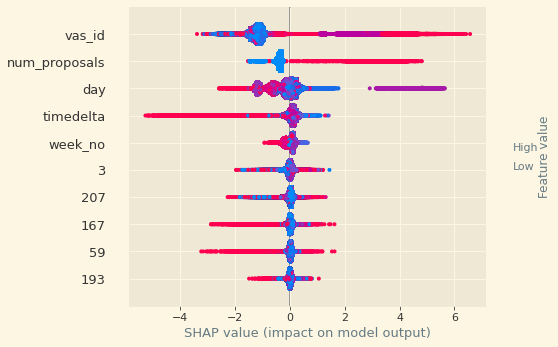

In [333]:
shap_values = cat.get_feature_importance(train_pool, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.summary_plot(shap_values, X[feats])

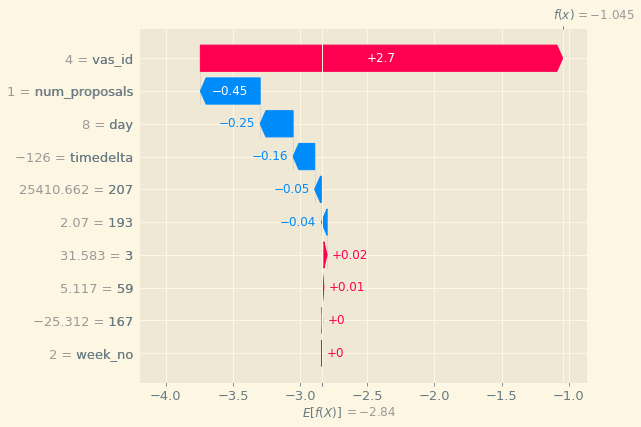

In [346]:
idx = 32
explainer = shap.TreeExplainer(cat)
shap_values_one = explainer(X[feats].iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

Confusion matrix, without normalization


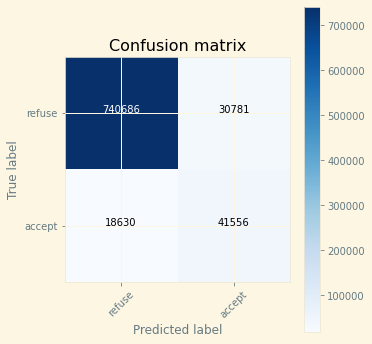

In [335]:
cnf_matrix = confusion_matrix(y, probs>=thres)
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['refuse', 'accept'], normalize=False,
                      title='Confusion matrix',)
plt.show()

AUC_ROC = 0.961


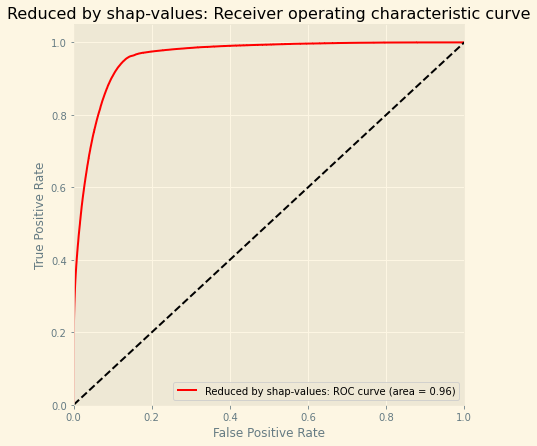

In [336]:
fpr, tpr, roc_thresholds = roc_curve(y, probs)
precision, recall, pr_thresholds = precision_recall_curve(y, probs)

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Reduced by shap-values", color='r')
print("AUC_ROC = %.3f" % auc(fpr, tpr))

AUC_PR = 0.711


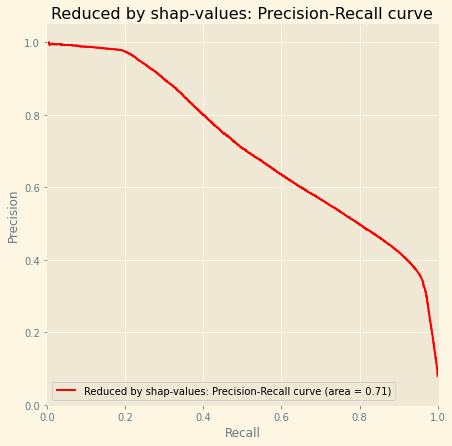

In [337]:
plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Reduced by shap-values", color='r')
print("AUC_PR = %.3f" % auc(recall, precision))

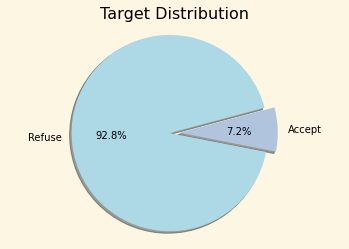

In [355]:
labels = 'Refuse','Accept'
colors = ['lightblue','lightsteelblue']
explode = (0, 0.1)
plt.pie(y.value_counts(), labels=labels, autopct='%1.1f%%', startangle=15, shadow=True, colors=colors, explode=explode)
plt.title('Target Distribution')
plt.axis('equal')
plt.show()